<a href="https://colab.research.google.com/github/Eieiz007/Deep-learning/blob/main/Seq2Seq_Attention_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam , AdamW
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Activation, Concatenate
import matplotlib.pyplot as plt


# Create data

In [2]:
date_range = pd.date_range(start="2023-01-01", end="2025-12-31", freq="D") #วันที่ 2 ปี

days = np.arange(len(date_range))
temperature = 25 + 5 * np.sin(2 * np.pi * days / 365) + np.random.normal(0, 2, len(days))
humidity = 60 + 10 * np.cos(2 * np.pi * days / 365) + np.random.normal(0, 5, len(days))
np.random.seed(42)

df = pd.DataFrame({
    "date": date_range,
    "temperature": temperature,
    "humidity": humidity
})

# แสดงตัวอย่างข้อมูล
df.head(10)


,date,temperature,humidity
0,2023-01-01,26.122883,70.603548
1,2023-01-02,27.197392,71.853047
2,2023-01-03,24.662819,71.837410
3,2023-01-04,24.573927,68.823921
4,2023-01-05,22.085451,71.500950
5,2023-01-06,22.587184,60.349064
6,2023-01-07,26.481996,76.657565
7,2023-01-08,27.343625,63.756251
8,2023-01-09,24.509129,72.994988
9,2023-01-10,26.514088,66.198398


array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>]], dtype=object)

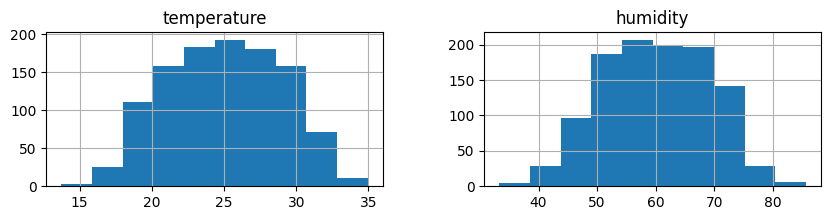

In [3]:
df.iloc[:,1:].hist(figsize=(10,2))

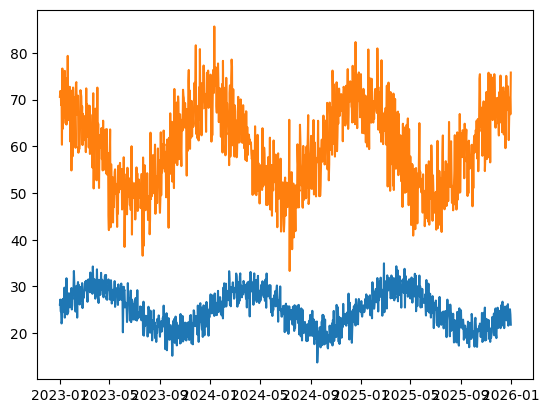

In [4]:
plt.plot(df['date'], df['temperature'])
plt.plot(df['date'], df['humidity'])

# Data prepartation for train model

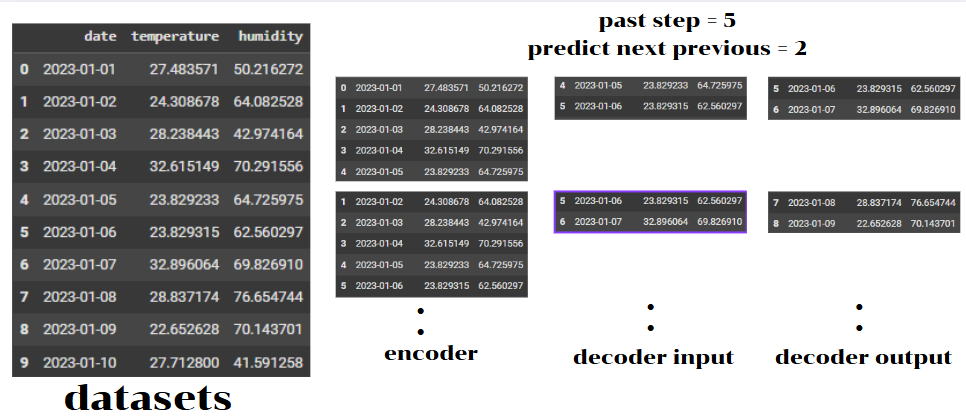

In [5]:
len(df)

1096

In [6]:
encoder_timesteps = 5  # ใช้ข้อมูลย้อนหลัง 5 วัน
decoder_timesteps = 2    # ทำนายอนาคต 2 วัน

X_encoder, Y_decoder_input, Y_decoder_output = [], [], []

for i in range(len(df) - encoder_timesteps - decoder_timesteps):
    # Encoder input (5 วันก่อนหน้า)          # 0 1 2 3 4
    X_encoder.append(df.iloc[i : i + encoder_timesteps][["temperature", "humidity"]].values)

    # Decoder input (ใช้ค่าจริงของ 2 วันถัดไป) # 4 5
    Y_decoder_input.append(df.iloc[i + encoder_timesteps-1 : (i + encoder_timesteps-1) + decoder_timesteps][["temperature", "humidity"]].values)

    # Decoder output (ค่าที่ต้องทำนาย)       # 5 6
    Y_decoder_output.append(df.iloc[i + encoder_timesteps: i + encoder_timesteps + decoder_timesteps][["temperature", "humidity"]].values)

# แปลงเป็น NumPy array
X_encoder = np.array(X_encoder)
Y_decoder_input = np.array(Y_decoder_input)
Y_decoder_output = np.array(Y_decoder_output)

# ตรวจสอบขนาดของข้อมูล
X_encoder.shape, Y_decoder_input.shape, Y_decoder_output.shape


((1089, 5, 2), (1089, 2, 2), (1089, 2, 2))

In [7]:
X_encoder[:3] , '**********************************************', Y_decoder_input[:1], '**********************************************', Y_decoder_output[:1]

(array([[[26.12288265, 70.60354836],
         [27.19739222, 71.85304717],
         [24.66281924, 71.83741045],
         [24.57392727, 68.82392147],
         [22.08545123, 71.50095036]],
 
        [[27.19739222, 71.85304717],
         [24.66281924, 71.83741045],
         [24.57392727, 68.82392147],
         [22.08545123, 71.50095036],
         [22.5871838 , 60.34906449]],
 
        [[24.66281924, 71.83741045],
         [24.57392727, 68.82392147],
         [22.08545123, 71.50095036],
         [22.5871838 , 60.34906449],
         [26.48199588, 76.65756456]]]),
 '**********************************************',
 array([[[22.08545123, 71.50095036],
         [22.5871838 , 60.34906449]]]),
 '**********************************************',
 array([[[22.5871838 , 60.34906449],
         [26.48199588, 76.65756456]]]))

# Data splitting and Normalization

In [8]:
X_train_enc, X_temp_enc    , Y_train_dec_in, Y_temp_dec_in ,     Y_train_dec_out, Y_temp_dec_out = train_test_split(
    X_encoder, Y_decoder_input, Y_decoder_output
    , test_size=0.3, shuffle=False
)

X_val_enc, X_test_enc,       Y_val_dec_in, Y_test_dec_in,       Y_val_dec_out, Y_test_dec_out = train_test_split(
    X_temp_enc, Y_temp_dec_in, Y_temp_dec_out
    , test_size=0.5, shuffle=False
)

print("Encoder Input Shapes:")
print(f"X_train_enc: {X_train_enc.shape}")
print(f"X_val_enc: {X_val_enc.shape}")
print(f"X_test_enc: {X_test_enc.shape}")

print("\nDecoder Input Shapes:")
print(f"Y_train_dec_in: {Y_train_dec_in.shape}")
print(f"Y_val_dec_in: {Y_val_dec_in.shape}")
print(f"Y_test_dec_in: {Y_test_dec_in.shape}")

print("\nDecoder Output Shapes:")
print(f"Y_train_dec_out: {Y_train_dec_out.shape}")
print(f"Y_val_dec_out: {Y_val_dec_out.shape}")
print(f"Y_test_dec_out: {Y_test_dec_out.shape}")


Encoder Input Shapes:
X_train_enc: (762, 5, 2)
X_val_enc: (163, 5, 2)
X_test_enc: (164, 5, 2)

Decoder Input Shapes:
Y_train_dec_in: (762, 2, 2)
Y_val_dec_in: (163, 2, 2)
Y_test_dec_in: (164, 2, 2)

Decoder Output Shapes:
Y_train_dec_out: (762, 2, 2)
Y_val_dec_out: (163, 2, 2)
Y_test_dec_out: (164, 2, 2)


In [9]:
scaler_enc = MinMaxScaler()
scaler_dec = MinMaxScaler()

X_train_enc_scaled = scaler_enc.fit_transform(X_train_enc.reshape(-1, X_train_enc.shape[-1])).reshape(X_train_enc.shape)
X_val_enc_scaled = scaler_enc.transform(X_val_enc.reshape(-1, X_val_enc.shape[-1])).reshape(X_val_enc.shape)
X_test_enc_scaled = scaler_enc.transform(X_test_enc.reshape(-1, X_test_enc.shape[-1])).reshape(X_test_enc.shape)

Y_train_dec_in_scaled = scaler_dec.fit_transform(Y_train_dec_in.reshape(-1, Y_train_dec_in.shape[-1])).reshape(Y_train_dec_in.shape)
Y_val_dec_in_scaled = scaler_dec.transform(Y_val_dec_in.reshape(-1, Y_val_dec_in.shape[-1])).reshape(Y_val_dec_in.shape)
Y_test_dec_in_scaled = scaler_dec.transform(Y_test_dec_in.reshape(-1, Y_test_dec_in.shape[-1])).reshape(Y_test_dec_in.shape)

Y_train_dec_out_scaled = scaler_dec.transform(Y_train_dec_out.reshape(-1, Y_train_dec_out.shape[-1])).reshape(Y_train_dec_out.shape)
Y_val_dec_out_scaled = scaler_dec.transform(Y_val_dec_out.reshape(-1, Y_val_dec_out.shape[-1])).reshape(Y_val_dec_out.shape)
Y_test_dec_out_scaled = scaler_dec.transform(Y_test_dec_out.reshape(-1, Y_test_dec_out.shape[-1])).reshape(Y_test_dec_out.shape)

print("After MinMax Scaling:")
print(f"X_train_enc_scaled: {X_train_enc_scaled.shape}")
print(f"X_val_enc_scaled: {X_val_enc_scaled.shape}")
print(f"X_test_enc_scaled: {X_test_enc_scaled.shape}")
print(f"Y_train_dec_in_scaled: {Y_train_dec_in_scaled.shape}")
print(f"Y_val_dec_in_scaled: {Y_val_dec_in_scaled.shape}")
print(f"Y_test_dec_in_scaled: {Y_test_dec_in_scaled.shape}")
print(f"Y_train_dec_out_scaled: {Y_train_dec_out_scaled.shape}")
print(f"Y_val_dec_out_scaled: {Y_val_dec_out_scaled.shape}")
print(f"Y_test_dec_out_scaled: {Y_test_dec_out_scaled.shape}")


After MinMax Scaling:
X_train_enc_scaled: (762, 5, 2)
X_val_enc_scaled: (163, 5, 2)
X_test_enc_scaled: (164, 5, 2)
Y_train_dec_in_scaled: (762, 2, 2)
Y_val_dec_in_scaled: (163, 2, 2)
Y_test_dec_in_scaled: (164, 2, 2)
Y_train_dec_out_scaled: (762, 2, 2)
Y_val_dec_out_scaled: (163, 2, 2)
Y_test_dec_out_scaled: (164, 2, 2)


# Train model

In [10]:
# Config
encoder_timesteps = 5   # จำนวนวันย้อนหลัง
decoder_timesteps = 2   # จำนวนวันที่ต้องการทำนาย
hidden_dim = 64         # ขนาดของ Hidden State
n_features = 2          # Temperature, Humidity
n_embedding = 30        # ขนาดของ Embedding ก่อนเข้า LSTM

# ===== Embedding Layer (ใช้กับทั้ง Encoder และ Decoder) =====
EmbedInput = Dense(n_embedding, activation='tanh')

# ===== Encoder =====
encoder_inputs = Input(shape=(encoder_timesteps, n_features))
e_enc = EmbedInput(encoder_inputs)  # Embedding ก่อนเข้า LSTM
encoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(e_enc)
encoder_states = [state_h, state_c]

# ===== Decoder =====
decoder_inputs = Input(shape=(decoder_timesteps, n_features))
e_dec = EmbedInput(decoder_inputs)  # Embedding ก่อนเข้า LSTM
decoder_lstm = LSTM(hidden_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(e_dec, initial_state=encoder_states)

# ===== Attention Layer =====
attention = Dot(axes=(2, 2))([decoder_outputs, encoder_outputs])  # Dot Product Attention
attention_score = Activation('softmax')(attention)  # Softmax เพื่อได้ Weight
context = Dot(axes=(2, 1))([attention_score, encoder_outputs])  # คูณ Score กับ Encoder Output
decoder_combined = Concatenate()([context, decoder_outputs])  # รวม Context + Decoder Output

# ===== Fully Connected Layer =====
decoder_dense = Dense(n_features, activation="linear")(decoder_combined)


# ===== Seq2Seq Model =====
model = Model([encoder_inputs, decoder_inputs], decoder_dense)
model.compile(optimizer=AdamW(learning_rate=0.00001), loss="mse")
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 2, 2)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer (InputLayer)  │ (None, 5, 2)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2, 30)          │             90 │ input_layer[0][0],     │
│                           │                        │                │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 5, 64), (None, │         24,320 │ dense[0][0]            │
│                           │ 64), (None, 64)]       │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 2, 64), (None, │         24,320 │ dense[1][0],           │
│                           │ 64), (None, 64)]       │                │ lstm[0][1], lstm[0][2] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot (Dot)                 │ (None, 2, 5)           │              0 │ lstm_1[0][0],          │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 2, 5)           │              0 │ dot[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dot_1 (Dot)               │ (None, 2, 64)          │              0 │ activation[0][0],      │
│                           │                        │                │ lstm[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 2, 128)         │              0 │ dot_1[0][0],           │
│                           │                        │                │ lstm_1[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2, 2)           │            258 │ concatenate[0][0]      │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 48,988 (191.36 KB)

 Trainable params: 48,988 (191.36 KB)

 Non-trainable params: 0 (0.00 B)

LSTM ออกมา 3 อย่าง output , h , c มันก็เลยเป็น shape 3 ตัว

In [19]:
history = model.fit(
    [X_train_enc_scaled, Y_train_dec_in_scaled], Y_train_dec_out_scaled,
    validation_data=([X_val_enc_scaled, Y_val_dec_in_scaled], Y_val_dec_out_scaled),
    epochs=100,
    batch_size=64
)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0231 - val_loss: 0.0331
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0217 - val_loss: 0.0324
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0215 - val_loss: 0.0317
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0222 - val_loss: 0.0311
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0210 - val_loss: 0.0305
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0209 - val_loss: 0.0300
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0216 - val_loss: 0.0294
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0208 - val_loss: 0.0290
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0207 - val_loss: 0.0285
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0194 - val_loss: 0.0281
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0200 - val_loss: 0.0277
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

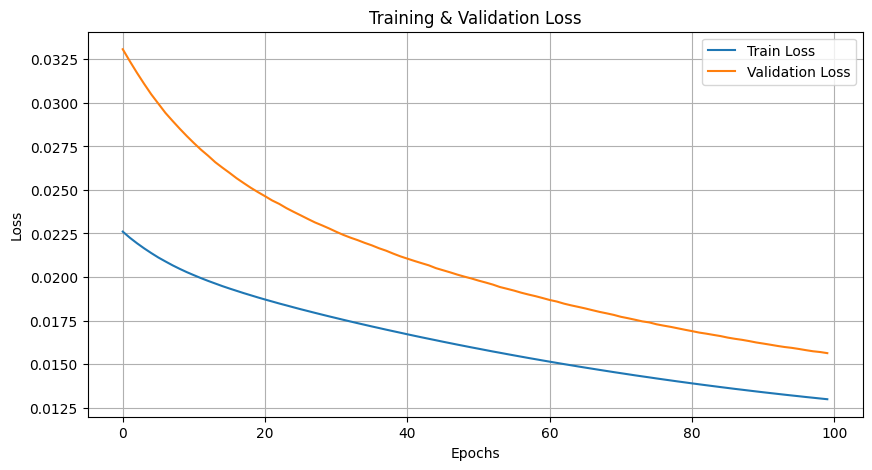

In [20]:

# ===== Plot กราฟ Loss =====
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid()
plt.show()


# Test

In [21]:
Y_pred_test_scaled = model.predict([X_test_enc_scaled, Y_test_dec_in_scaled])
print(f"Prediction Shape: {Y_pred_test_scaled.shape}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Prediction Shape: (164, 2, 2)


In [22]:
# แปลงค่ากลับเป็นค่าเดิม
Y_pred_test = scaler_dec.inverse_transform(Y_pred_test_scaled.reshape(-1, Y_pred_test_scaled.shape[-1])).reshape(Y_pred_test_scaled.shape)

# แปลงค่าจริงกลับเป็นค่าเดิม
Y_test_dec_out_original = scaler_dec.inverse_transform(Y_test_dec_out_scaled.reshape(-1, Y_test_dec_out_scaled.shape[-1])).reshape(Y_test_dec_out_scaled.shape)
Y_test_dec_out_original.shape

(164, 2, 2)

In [23]:
Y_test_dec_out_original[: , 0 , 0]

array([22.97679175, 24.63887807, 21.03399491, 23.63286317, 22.65391483,
       22.52063873, 24.75189056, 23.53861521, 24.1697765 , 19.15565652,
       24.12820424, 27.18430785, 24.53873322, 25.86649389, 24.58194555,
       23.64844319, 22.77259181, 19.33372614, 26.11910203, 24.27057653,
       20.47894142, 24.16511639, 22.85973593, 20.78886909, 21.42976306,
       24.1686179 , 21.34761653, 18.01674197, 21.07593872, 22.78273863,
       19.22581171, 21.20108618, 20.70950387, 18.02888112, 19.86744073,
       24.55500858, 20.18736327, 23.12456473, 17.80602569, 17.33784554,
       25.3235103 , 21.16243616, 21.79403567, 21.60351982, 24.90094449,
       21.29343883, 22.11278784, 21.88912336, 21.00685548, 22.8998604 ,
       21.96937438, 18.59893789, 20.44171313, 19.26685504, 21.6279259 ,
       20.81176046, 19.03161048, 20.74920557, 19.69620696, 17.87065998,
       19.53095998, 22.477355  , 20.05092446, 18.20325054, 16.99647938,
       19.85186782, 22.21597753, 18.96326009, 21.2239361 , 18.77

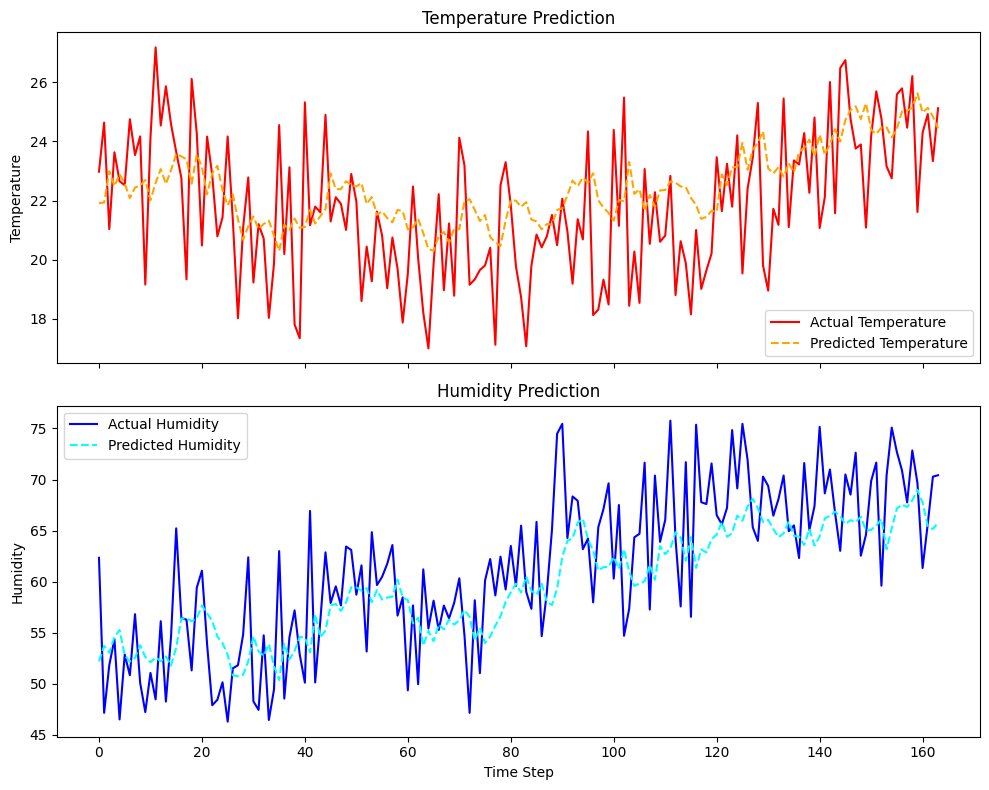

In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10,8), sharex=True)

axes[0].plot(Y_test_dec_out_original[:, 0, 0], label="Actual Temperature", color="red")
axes[0].plot(Y_pred_test[:, 0, 0], label="Predicted Temperature", linestyle="dashed", color="orange")
axes[0].set_ylabel("Temperature")
axes[0].set_title("Temperature Prediction")
axes[0].legend()

axes[1].plot(Y_test_dec_out_original[:, 0, 1], label="Actual Humidity", color="blue")
axes[1].plot(Y_pred_test[:, 0, 1], label="Predicted Humidity", linestyle="dashed", color="cyan")
axes[1].set_ylabel("Humidity")
axes[1].set_title("Humidity Prediction")
axes[1].legend()

axes[1].set_xlabel("Time Step")

plt.tight_layout()
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_temp_scaled = mean_squared_error(Y_test_dec_out_scaled[:, :, 0], Y_pred_test_scaled[:, :, 0])
rmse_temp_scaled = np.sqrt(mse_temp_scaled)
mae_temp_scaled = mean_absolute_error(Y_test_dec_out_scaled[:, :, 0], Y_pred_test_scaled[:, :, 0])

mse_humid_scaled = mean_squared_error(Y_test_dec_out_scaled[:, :, 1], Y_pred_test_scaled[:, :, 1])
rmse_humid_scaled = np.sqrt(mse_humid_scaled)
mae_humid_scaled = mean_absolute_error(Y_test_dec_out_scaled[:, :, 1], Y_pred_test_scaled[:, :, 1])

print("=== Test Score (Before Inverse Transform) ===")
print(f"Temperature - MSE: {mse_temp_scaled:.6f}, RMSE: {rmse_temp_scaled:.6f}, MAE: {mae_temp_scaled:.6f}")
print(f"Humidity - MSE: {mse_humid_scaled:.6f}, RMSE: {rmse_humid_scaled:.6f}, MAE: {mae_humid_scaled:.6f}")

=== Test Score (Before Inverse Transform) ===
Temperature - MSE: 0.013150, RMSE: 0.114673, MAE: 0.094312
Humidity - MSE: 0.010737, RMSE: 0.103619, MAE: 0.083006


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse_temp = mean_squared_error(Y_test_dec_out_original[:, 0, 0], Y_pred_test[:, 0, 0])
rmse_temp = np.sqrt(mse_temp)
mae_temp = mean_absolute_error(Y_test_dec_out_original[:, 0, 0], Y_pred_test[:, 0, 0])

mse_humid = mean_squared_error(Y_test_dec_out_original[:, 0, 1], Y_pred_test[:, 0, 1])
rmse_humid = np.sqrt(mse_humid)
mae_humid = mean_absolute_error(Y_test_dec_out_original[:, 0, 1], Y_pred_test[:, 0, 1])

print("=== Test Score ===")
print(f"Temperature - MSE: {mse_temp:.4f}, RMSE: {rmse_temp:.4f}, MAE: {mae_temp:.4f}")
print(f"Humidity - MSE: {mse_humid:.4f}, RMSE: {rmse_humid:.4f}, MAE: {mae_humid:.4f}")

=== Test Score ===
Temperature - MSE: 4.9099, RMSE: 2.2158, MAE: 1.8216
Humidity - MSE: 31.1139, RMSE: 5.5780, MAE: 4.4794
